In [1]:
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from numpy.random import seed
import tensorflow as tf


In [3]:
path = "C:/Users/riasi/Desktop/dataset/COVID-19_Radiography_Dataset"

classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
num_classes = len(classes)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.2)

train_gen = train_datagen.flow_from_directory(directory=path, 
                                              target_size=(75, 75),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=path, 
                                              target_size=(75, 75),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="rgb")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

In [5]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
from keras import layers

In [7]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', metrics = ['acc'])

C:\Users\riasi\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)
callbacks_list = [learning_rate_reduction,early_stopping_monitor]

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
model.fit(train_gen, validation_data = test_gen, epochs = 80, batch_size = 128, callbacks = [callbacks_list])

Epoch 1/80
1059/1059 [==============================] - 308s 289ms/step - loss: 0.8668 - acc: 0.6525 - val_loss: 0.7466 - val_acc: 0.7056
Epoch 2/80
1059/1059 [==============================] - 201s 190ms/step - loss: 0.7740 - acc: 0.6996 - val_loss: 0.7081 - val_acc: 0.7202
Epoch 3/80
1059/1059 [==============================] - 197s 186ms/step - loss: 0.7542 - acc: 0.7020 - val_loss: 0.7063 - val_acc: 0.7287
Epoch 4/80
1059/1059 [==============================] - 198s 187ms/step - loss: 0.7380 - acc: 0.7152 - val_loss: 0.7353 - val_acc: 0.7183
Epoch 5/80
1059/1059 [==============================] - 203s 192ms/step - loss: 0.7263 - acc: 0.7182 - val_loss: 0.6800 - val_acc: 0.7401
Epoch 6/80
1059/1059 [==============================] - 201s 190ms/step - loss: 0.7113 - acc: 0.7245 - val_loss: 0.6955 - val_acc: 0.7351
Epoch 7/80
1059/1059 [==============================] - 197s 186ms/step - loss: 0.7158 - acc: 0.7233 - val_loss: 0.7442 - val_acc: 0.7155
Epoch 8/80
1059/1059 [============

In [11]:
model.save('inceptionV3.h5')

In [10]:
inceptionV3 = keras.models.load_model('inceptionV3.h5')

In [11]:
y_pred = inceptionV3.predict(test_gen)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
y_true=test_gen.classes
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
class_report = classification_report(y_true, predictions, target_names = ['Covid-19', 'Lung Opacity', 'Healthy', 'Pneumonia'])

In [14]:
print(class_report)

              precision    recall  f1-score   support

    Covid-19       0.72      0.56      0.63       723
Lung Opacity       0.78      0.75      0.76      1202
     Healthy       0.79      0.86      0.82      2038
   Pneumonia       0.71      0.79      0.75       269

    accuracy                           0.77      4232
   macro avg       0.75      0.74      0.74      4232
weighted avg       0.77      0.77      0.77      4232



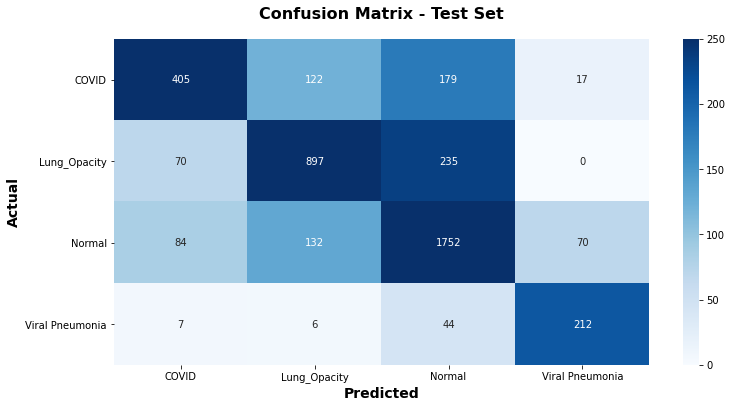

In [15]:
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);